In [3]:
import os
import io
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.utils import Bunch
import joblib

## Importing and describing Dataset

In [4]:
data_path = "spam.csv"
assert os.path.exists(data_path), f"Dataset not found at {data_path}"

In [6]:
df_raw = pd.read_csv(data_path, encoding="latin1", engine="python")
# Try to normalize columns to ['label', 'message']
df = df_raw.copy()

In [7]:
lower_cols = [str(c).strip().lower() for c in df.columns]

In [8]:
if set(lower_cols) >= {"v1", "v2"}:
    # UCI format
    df = df.rename(columns={df.columns[0]: "label", df.columns[1]: "message"})
    # Drop extra columns if any
    if df.shape[1] > 2:
        df = df[["label", "message"]]
elif "label" in lower_cols and "message" in lower_cols:
    # Already good
    pass
else:
    # Try to infer
    # Assume first text-like column is label and second is message
    # Safer approach: if there are exactly two columns, use them
    if df.shape[1] >= 2:
        df = df.iloc[:, :2]
        df.columns = ["label", "message"]
    else:
        raise ValueError("Could not infer columns for label/message. Ensure CSV has two columns: label, message.")

In [ ]:
# Striping and normalizing
df["label"] = df["label"].astype(str).str.strip().str.lower()
df["message"] = df["message"].astype(str).str.strip()

In [ ]:
# Basic cleaning: droping NA and duplicates
df = df.dropna(subset=["label", "message"]).drop_duplicates().reset_index(drop=True)

In [11]:
# Describe dataset
shape_info = df.shape
label_counts = df["label"].value_counts(dropna=False).rename_axis("label").reset_index(name="count")
class_ratio = (label_counts.set_index("label")["count"] / len(df)).reset_index(name="ratio")

In [14]:
# Show to user
print("Dataset Preview (first 10 rows)")
print(df.head(10))
print("Label Counts")
print(label_counts)
print("Class Ratio")
print(class_ratio)

Dataset Preview (first 10 rows)
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
5  spam  FreeMsg Hey there darling it's been 3 week's n...
6   ham  Even my brother is not like to speak with me. ...
7   ham  As per your request 'Melle Melle (Oru Minnamin...
8  spam  WINNER!! As a valued network customer you have...
9  spam  Had your mobile 11 months or more? U R entitle...
Label Counts
  label  count
0   ham   4516
1  spam    642
Class Ratio
  label     ratio
0   ham  0.875533
1  spam  0.124467


## Exploratory Data Analysis (EDA) with Visualizations

In [ ]:
# Adding simple text-length features
df["char_len"] = df["message"].str.len()
df["word_len"] = df["message"].str.split().apply(len)

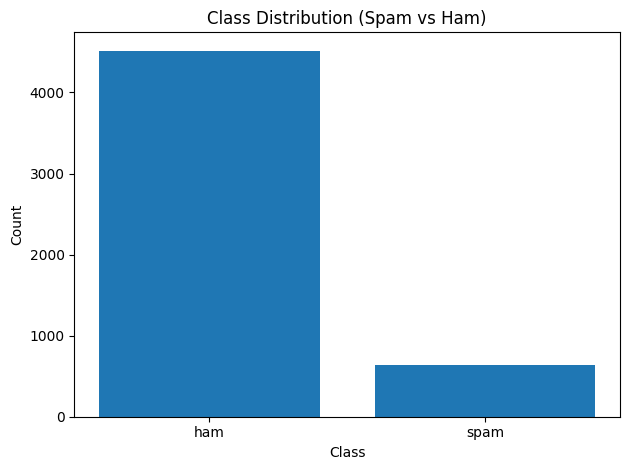

In [16]:
# Plot 1: Class distribution
plt.figure()
label_counts_plot = label_counts.copy()
plt.bar(label_counts_plot["label"], label_counts_plot["count"])
plt.title("Class Distribution (Spam vs Ham)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

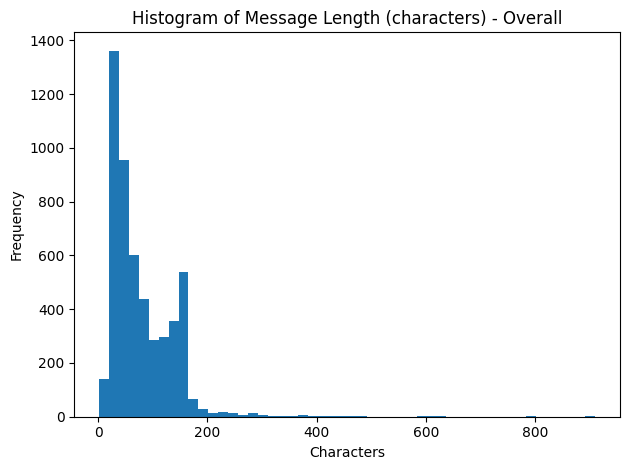

In [17]:
# Plot 2: Histogram of message length (characters) - overall
plt.figure()
plt.hist(df["char_len"], bins=50)
plt.title("Histogram of Message Length (characters) - Overall")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

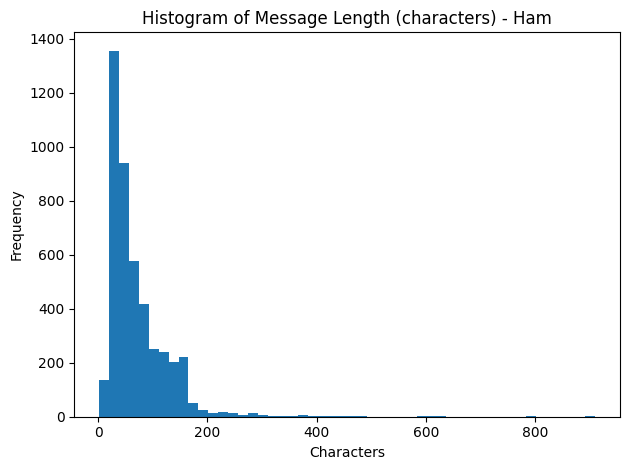

In [18]:
# Plot 3: Histogram of message length (characters) - ham only
plt.figure()
plt.hist(df.loc[df["label"] == "ham", "char_len"], bins=50)
plt.title("Histogram of Message Length (characters) - Ham")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

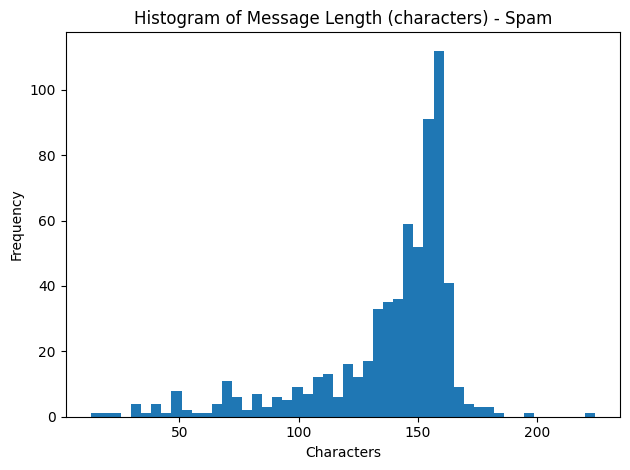

In [19]:
# Plot 4: Histogram of message length (characters) - spam only
plt.figure()
plt.hist(df.loc[df["label"] == "spam", "char_len"], bins=50)
plt.title("Histogram of Message Length (characters) - Spam")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [21]:
# Plot 5 & 6: Top 20 words in ham vs spam (CountVectorizer)
def top_terms_by_class(df, label_value, topn=20):
    vec = CountVectorizer(stop_words="english", lowercase=True)
    X = vec.fit_transform(df.loc[df["label"] == label_value, "message"])
    term_sums = np.asarray(X.sum(axis=0)).ravel()
    terms = np.array(vec.get_feature_names_out())
    order = term_sums.argsort()[::-1][:topn]
    return pd.DataFrame({"term": terms[order], "count": term_sums[order]})

top_ham = top_terms_by_class(df, "ham", topn=20)
top_spam = top_terms_by_class(df, "spam", topn=20)

print("Top 20 Terms - Ham")
print(top_ham)
print("Top 20 Terms - Spam")
print(top_spam)

Top 20 Terms - Ham
     term  count
0      gt    288
1      lt    287
2    just    278
3      ok    255
4      ll    232
5     got    226
6    know    225
7    like    222
8    good    215
9    come    211
10     ur    198
11   time    192
12    day    182
13   love    180
14  going    164
15   want    160
16    lor    159
17   home    156
18   need    154
19    don    144
Top 20 Terms - Spam
      term  count
0     free    190
1      txt    132
2       ur    119
3     stop    109
4     text    108
5   mobile    105
6    reply     96
7    claim     95
8      www     81
9    prize     79
10    just     65
11     new     64
12    cash     64
13    150p     61
14      uk     59
15    send     58
16     won     58
17  urgent     57
18   nokia     53
19     msg     50


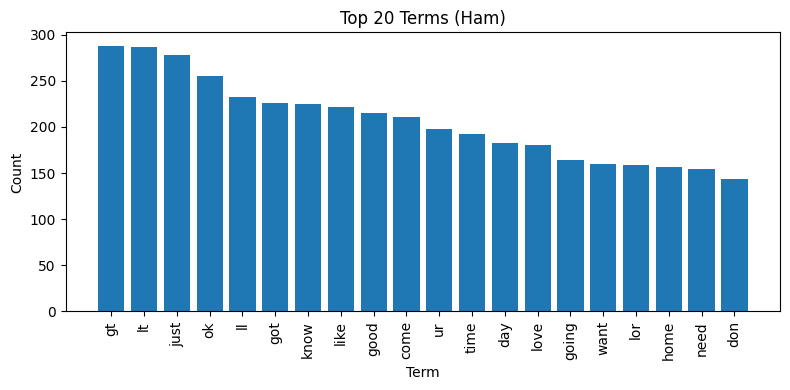

In [22]:
# Plot 5: Top 20 Ham terms
plt.figure(figsize=(8, 4))
plt.bar(top_ham["term"], top_ham["count"])
plt.title("Top 20 Terms (Ham)")
plt.xlabel("Term")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

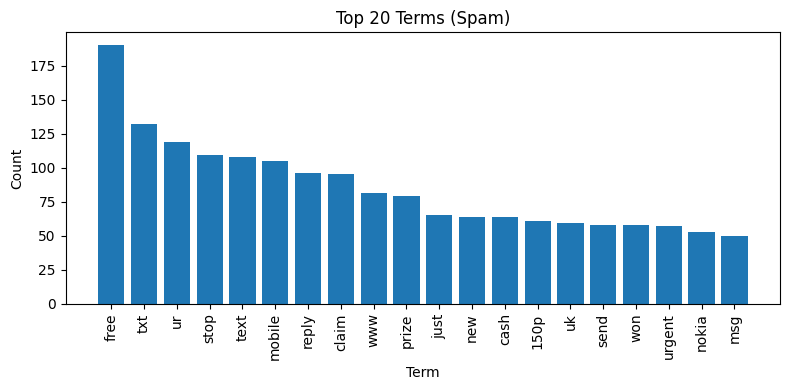

In [23]:
# Plot 6: Top 20 Spam terms
plt.figure(figsize=(8, 4))
plt.bar(top_spam["term"], top_spam["count"])
plt.title("Top 20 Terms (Spam)")
plt.xlabel("Term")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [25]:
# Quick statistical summary
summary_stats = pd.DataFrame({
    "metric": ["n_samples", "n_features", "pct_spam", "pct_ham", "avg_char_len", "avg_word_len"],
    "value": [
        len(df),
        None,  # will be known after vectorization; placeholder
        (df["label"] == "spam").mean(),
        (df["label"] == "ham").mean(),
        df["char_len"].mean(),
        df["word_len"].mean(),
    ]
})
print("Summary Statistics (pre-vectorization)")
print(summary_stats)

Summary Statistics (pre-vectorization)
         metric        value
0     n_samples  5158.000000
1    n_features          NaN
2      pct_spam     0.124467
3       pct_ham     0.875533
4  avg_char_len    78.783249
5  avg_word_len    15.317759


## Interpret EDA & Decide Modeling Approach (printed text)

In [26]:
interpretation = """
EDA Interpretation & Modeling Decision:
- The dataset shows an imbalanced but manageable class distribution (typically ham > spam).
- Spam messages tend to be longer on average (characters/words), and contain promotional / action-oriented terms.
- Bag-of-words or TF-IDF representations are strong baselines for SMS classification.
- We will compare traditional ML models (MultinomialNB, Logistic Regression, Linear SVM) using TF-IDF features.
- We'll use Stratified K-Fold (k=5) with Grid Search for hyperparameter tuning.
- The best-performing model on validation F1 will be persisted and used in a Streamlit app.
"""
print(interpretation)


EDA Interpretation & Modeling Decision:
- The dataset shows an imbalanced but manageable class distribution (typically ham > spam).
- Spam messages tend to be longer on average (characters/words), and contain promotional / action-oriented terms.
- Bag-of-words or TF-IDF representations are strong baselines for SMS classification.
- We will compare traditional ML models (MultinomialNB, Logistic Regression, Linear SVM) using TF-IDF features.
- We'll use Stratified K-Fold (k=5) with Grid Search for hyperparameter tuning.
- The best-performing model on validation F1 will be persisted and used in a Streamlit app.



## Training & Evaluating ML with K-Fold CV + Grid Search

In [27]:
# Preparing data
X = df["message"].values
y = df["label"].values

In [29]:
# Train/Test split for final holdout evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Defining pipelines and grids
pipelines_and_grids = []

In [31]:
# 1) Multinomial Naive Bayes
pipe_nb = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, stop_words="english", strip_accents="unicode")),
    ("clf", MultinomialNB())
])
grid_nb = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2],
    "clf__alpha": [0.1, 0.5, 1.0]
}
pipelines_and_grids.append(("MultinomialNB", pipe_nb, grid_nb))

In [32]:
# 2) Logistic Regression
pipe_lr = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, stop_words="english", strip_accents="unicode")),
    ("clf", LogisticRegression(max_iter=200, solver="liblinear"))
])
grid_lr = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2],
    "clf__C": [0.5, 1.0, 2.0],
    "clf__penalty": ["l2"]
}
pipelines_and_grids.append(("LogisticRegression", pipe_lr, grid_lr))

In [33]:
# 3) Linear SVM
pipe_svm = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, stop_words="english", strip_accents="unicode")),
    ("clf", LinearSVC())
])
grid_svm = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2],
    "clf__C": [0.5, 1.0, 2.0]
}
pipelines_and_grids.append(("LinearSVC", pipe_svm, grid_svm))


In [34]:
results = []
best_models = {}

In [36]:
for name, pipe, grid in pipelines_and_grids:
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        scoring="f1_macro",   # macro to balance classes
        cv=cv,
        n_jobs=-1,
        verbose=0
    )
    gs.fit(X_train, y_train)
    best_models[name] = gs.best_estimator_
    # Evaluate on validation (cv) score and on test split
    val_score = gs.best_score_
    y_pred_test = gs.best_estimator_.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred_test)
    pr, rc, f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average="macro", zero_division=0)
    results.append({
        "model": name,
        "best_params": gs.best_params_,
        "cv_f1_macro": val_score,
        "test_accuracy": test_acc,
        "test_precision_macro": pr,
        "test_recall_macro": rc,
        "test_f1_macro": f1
    })

results_df = pd.DataFrame(results).sort_values("cv_f1_macro", ascending=False).reset_index(drop=True)
print("Model Comparison (Validation + Test Metrics)", results_df)


Model Comparison (Validation + Test Metrics)                 model                                        best_params  \
0       MultinomialNB  {'clf__alpha': 0.1, 'tfidf__min_df': 1, 'tfidf...   
1       MultinomialNB  {'clf__alpha': 0.1, 'tfidf__min_df': 1, 'tfidf...   
2           LinearSVC  {'clf__C': 2.0, 'tfidf__min_df': 2, 'tfidf__ng...   
3           LinearSVC  {'clf__C': 2.0, 'tfidf__min_df': 2, 'tfidf__ng...   
4  LogisticRegression  {'clf__C': 2.0, 'clf__penalty': 'l2', 'tfidf__...   
5  LogisticRegression  {'clf__C': 2.0, 'clf__penalty': 'l2', 'tfidf__...   

   cv_f1_macro  test_accuracy  test_precision_macro  test_recall_macro  \
0     0.963464       0.984496              0.976754           0.950913   
1     0.963464       0.984496              0.976754           0.950913   
2     0.959592       0.986434              0.981469           0.955372   
3     0.959592       0.986434              0.981469           0.955372   
4     0.923545       0.977713              0.983435 

In [ ]:
# Picking best by validation F1
best_row = results_df.iloc[0]
best_model_name = best_row["model"]
best_pipeline = best_models[best_model_name]

print(f"Selected Best Model: {best_model_name}")
print("Best Validation F1 (macro):", round(best_row["cv_f1_macro"], 4))
print("Test Accuracy:", round(best_row["test_accuracy"], 4))
print("Test Precision (macro):", round(best_row["test_precision_macro"], 4))
print("Test Recall (macro):", round(best_row["test_recall_macro"], 4))
print("Test F1 (macro):", round(best_row["test_f1_macro"], 4))

Selected Best Model: MultinomialNB
Best Validation F1 (macro): 0.9635
Test Accuracy: 0.9845
Test Precision (macro): 0.9768
Test Recall (macro): 0.9509
Test F1 (macro): 0.9633


In [38]:
# Confusion matrix on test set
cm = confusion_matrix(y_test, best_pipeline.predict(X_test), labels=["ham", "spam"])
cm_df = pd.DataFrame(cm, index=["true_ham", "true_spam"], columns=["pred_ham", "pred_spam"])
print("Confusion Matrix (Test Set)", cm_df)

Confusion Matrix (Test Set)            pred_ham  pred_spam
true_ham        900          4
true_spam        12        116


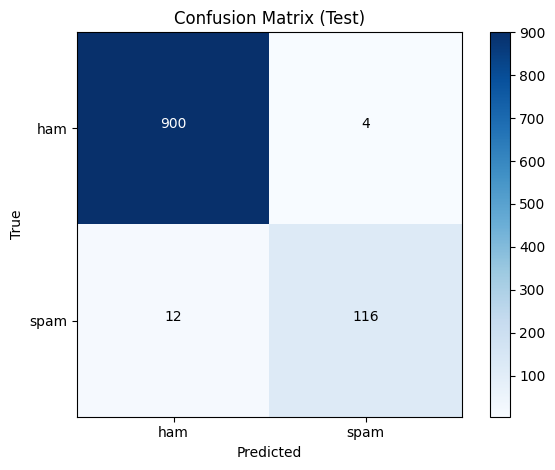

In [43]:
plt.figure()
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Test)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["ham", "spam"])
plt.yticks(tick_marks, ["ham", "spam"])

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [44]:
# Detailed classification report
report_text = classification_report(y_test, best_pipeline.predict(X_test))
print("Classification Report (Best Model on Test Set):\n")
print(report_text)

Classification Report (Best Model on Test Set):

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       904
        spam       0.97      0.91      0.94       128

    accuracy                           0.98      1032
   macro avg       0.98      0.95      0.96      1032
weighted avg       0.98      0.98      0.98      1032



## Selecting and saving the best model

In [46]:
model_path = "sms_spam_best_model.joblib"
joblib.dump(best_pipeline, model_path)
print(f"Best model saved to: {model_path}")

Best model saved to: sms_spam_best_model.joblib


## Loading saved model and making predictions from new data

In [48]:
loaded_model = joblib.load(model_path)
samples = [
    "Congratulations! You have won a free ticket. Call now to claim your prize.",
    "Hey, are we meeting at 5 pm today near the cafe?",
    "URGENT! Your account has been suspended. Verify your identity immediately.",
    "Please review the attached report and share your feedback."
]
preds = loaded_model.predict(samples)
proba_support = hasattr(loaded_model.named_steps["clf"], "predict_proba")
if proba_support:
    proba = loaded_model.predict_proba(samples).max(axis=1)
else:
    # For models without predict_proba (e.g., LinearSVC), use decision_function scaled
    if hasattr(loaded_model.named_steps["clf"], "decision_function"):
        scores = loaded_model.decision_function(samples)
        # Convert decision scores to 0..1 via a simple logistic transform for display
        proba = 1 / (1 + np.exp(-np.abs(scores)))
        if proba.ndim > 1:
            proba = proba.max(axis=1)
    else:
        proba = np.array([np.nan]*len(samples))

pred_df = pd.DataFrame({"text": samples, "prediction": preds, "confidence": proba})
print("Sample Predictions (Loaded Model)", pred_df)

# -----------------------------

Sample Predictions (Loaded Model)                                                 text prediction  confidence
0  Congratulations! You have won a free ticket. C...       spam    0.990491
1   Hey, are we meeting at 5 pm today near the cafe?        ham    0.996655
2  URGENT! Your account has been suspended. Verif...       spam    0.897642
3  Please review the attached report and share yo...        ham    0.960726


## Generating a Streamlit App + Project Files, and Zip for GitHub

In [50]:
project_dir = "sms_spam_project"
os.makedirs(project_dir, exist_ok=True)

# Save the model into the project
project_model_path = os.path.join(project_dir, "sms_spam_best_model.joblib")
joblib.dump(best_pipeline, project_model_path)

['sms_spam_project\\sms_spam_best_model.joblib']